In [10]:
# moduli usati
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy  as np

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_folder = Path("/content/drive/MyDrive/data")

Mounted at /content/drive


# Leggiamo i dati meteo

In [12]:
mt = pd.read_csv(data_folder / "mt/processed/t0408_mezzolombardo.csv", parse_dates=["Data"])
mt = mt.dropna()

mt

,Data,Valore,Qualità,Variabile,Unità di misura
1,2012-05-31 11:10:00,0.0,1.0,Precipitazione,mm
2,2012-05-31 11:15:00,0.0,1.0,Precipitazione,mm
3,2012-05-31 11:20:00,0.0,1.0,Precipitazione,mm
4,2012-05-31 11:25:00,0.0,1.0,Precipitazione,mm
5,2012-05-31 11:30:00,0.0,1.0,Precipitazione,mm
...,...,...,...,...,...
1698897,2024-02-12 23:00:00,4.9,145.0,Temperatura,°C
1698898,2024-02-12 23:15:00,4.6,145.0,Temperatura,°C
1698899,2024-02-12 23:30:00,4.4,145.0,Temperatura,°C
1698900,2024-02-12 23:45:00,4.6,145.0,Temperatura,°C


## Qualità del dato

Andiamo a vedere qual è la qualità dei dati nel nostro dataset secondo la seguente legenda.

* 1 - Dato buono
* 140 - dato incerto, per analisi climatiche o malfunzionamento stazione
* 145 - da teletrasmissione, non validato

In [13]:
mt.Qualità.value_counts()

,count
Qualità,
1.0,1612763
145.0,82526
140.0,3578


In [14]:
mt.groupby([mt.Data.dt.year, "Variabile", mt.Qualità]).count()

Data  Valore  Unità di misura
Data Variabile             Qualità                                 
2012 Precipitazione        1.0       50979   50979            50979
                           140.0      1476    1476             1476
     Temperatura           1.0       17488   17488            17488
2013 Precipitazione        1.0      103582  103582           103582
                           140.0      1370    1370             1370
     Temperatura           1.0       34999   34999            34999
2014 Precipitazione        1.0      104729  104729           104729
                           140.0       349     349              349
     Temperatura           1.0       35032   35032            35032
2015 Precipitazione        1.0      105103  105103           105103
     Temperatura           1.0       35033   35033            35033
2016 Precipitazione        1.0      105350  105350           105350
     Temperatura           1.0       35117   35117            35117
2017 Precipitazione        1.0      105023  105023           105023
     Temperatura           1.0       34999   34999            34999
                           140.0         8       8                8
2018 Precipitazione        1.0      105005  105005           105005
                           140.0        60      60               60
     Temperatura           1.0       35018   35018            35018
2019 Precipitazione        1.0      105012  105012           105012
     Temperatura           1.0       35001   35001            35001
2020 Precipitazione        1.0      105071  105071           105071
                           140.0       314     314              314
     Temperatura           1.0       35125   35125            35125
                           140.0         1       1                1
2021 Precipitazione        1.0      105114  105114           105114
     Pressione Atmosferica 1.0           1       1                1
                           145.0       142     142              142
     Temperatura           1.0       35037   35037            35037
2022 Precipitazione        1.0      105109  105109           105109
     Pressione Atmosferica 145.0     35037   35037            35037
     Temperatura           1.0       35037   35037            35037
2023 Precipitazione        1.0      102894  102894           102894
     Pressione Atmosferica 145.0     34309   34309            34309
     Temperatura           1.0       31650   31650            31650
                           145.0      2650    2650             2650
2024 Precipitazione        1.0       10255   10255            10255
                           145.0      2130    2130             2130
     Pressione Atmosferica 145.0      4129    4129             4129
     Temperatura           145.0      4129    4129             4129

## Grafici

Teniamo solo i dati di qualità pari a 1.

In [15]:
mt = mt[mt.Qualità == 1]

Grafichiamo le variabili  temperatura e precipitazione. Si riporta parte del codice di seguito:

```
mt[(mt.Variabile == "Precipitazione") & (mt.Data.dt.year==2021)].plot(x="Data", y="Valore", title="Precipitazione", ylabel="mm")
```

Possiamo anche osservare l'andamento dei valori medi (mean) o cumulati (sum) giornalieri (D), settimanali (W), mensili (M) o annuali (A).
```
mt[(mt.Variabile == "Precipitazione") & (mt.Data.dt.year==2021)].set_index("Data").resample("D").sum().reset_index().plot(x="Data", y="Valore", title="Precipitazione", ylabel="mm")
```

<Axes: title={'center': 'Temperatura'}, xlabel='Data', ylabel='mm'>

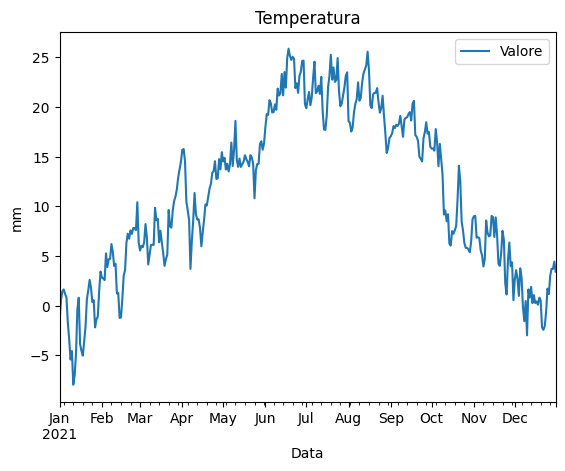

In [41]:
mt[(mt.Variabile == "Temperatura") & (mt.Data.dt.year==2021)].set_index("Data")["Valore"].resample("D").mean().reset_index().plot(x="Data", y="Valore", title="Temperatura", ylabel="mm")

# Previsione del valore medio giornaliero di PM10 unendo il dataset meteo e il dataset APPA

## Costruzione del dato

### Calcolo dei dati giornalieri

I dati meteo possono essere utilizzati all'interno della nostra matrice X del modello di machine learning come nuove features.

Calcoliamo i dati giornalieri scegliendo i mm totali per la pioggia e la temperatura media.

In [17]:
# definisco come aggregare i dati
agg = {"Precipitazione": "sum", "Temperatura": "mean"}

In [18]:
# genero i dati giornalieri
weather = (
    mt[["Data", "Valore", "Variabile"]]
    .dropna()
    .pivot_table(index="Data", columns="Variabile", values="Valore")
    .resample("D")
    .agg(agg)
    .sort_index()
)
weather

Variabile,Precipitazione,Temperatura
Data,,
2012-05-31,0.0,23.042308
2012-06-01,0.0,22.032292
2012-06-02,0.0,22.989583
2012-06-03,0.0,22.976042
2012-06-04,0.0,16.581250
...,...,...
2024-02-01,0.0,NaN
2024-02-02,0.0,NaN
2024-02-03,0.0,NaN


### Leggiamo i dati di APPA

Riprendiamo la lettura dei dati APPA dal notebook della scorsa lezione. Come nella precedente lezione carichiamo i dati di APPA, selezioniamo la stazione e calcoliamo i valori medi orari per ogni inquinante in modo da ottenere la tabella pivot usata per il calcolo della correlazione nella scorsa lezione.

In [19]:
appa = pd.read_csv(
    data_folder / "DataSet_APPA/processed/appa_data.csv", parse_dates=["Data"]
)
# definiamo la stazione da analizzare
station = "Piana Rotaliana"
exp_data = appa.loc[(appa.Stazione == station)].set_index("Data").groupby(["Inquinante"]).resample("D").mean("Valore").reset_index()
# converto i nomi degli inquinanti in codici (formule chimiche o abbreviazioni)
exp_data["Inquinante"] = exp_data.Inquinante.map(
    {"PM10": "PM10", "Biossido di Azoto": "NO2", "Ozono": "O3"}
)
# converto il dataframe in una tabella pivot (formato wide) e ordino i dati per data
exp_data = exp_data.pivot_table(
    index="Data", columns="Inquinante", values="Valore"
).sort_index()

exp_data

Inquinante,NO2,O3,PM10
Data,,,
2011-01-01,40.913043,8.652174,42.304348
2011-01-02,49.666667,8.083333,36.125000
2011-01-03,29.125000,30.250000,20.458333
2011-01-04,32.458333,21.750000,27.916667
2011-01-05,34.833333,20.791667,30.416667
...,...,...,...
2023-12-29,28.500000,6.250000,22.541667
2023-12-30,25.750000,9.125000,22.875000
2023-12-31,26.708333,4.500000,22.083333


### Unione dei dataset

Costruiamo un unico datateset concatenando le features che riteniamo utili partendo dal modello della lezione scorsa e dalle osservazioni sui dati meteo.

Creiamo la serie per le variabili che riteniamo utili al modello:
* temp_series `temp_series = weather["Temperatura"]`
* rain_series `rain_series = weather["Precipitazione"]`
* pollutant_series `pollutant_series = exp_data["PM10"]`

In [20]:
temp_series = weather["Temperatura"].sort_index()
rain_series = weather["Precipitazione"].sort_index()
pollutant_series = exp_data["PM10"].sort_index()
temp_series

,Temperatura
Data,
2012-05-31,23.042308
2012-06-01,22.032292
2012-06-02,22.989583
2012-06-03,22.976042
2012-06-04,16.581250
...,...
2024-02-01,NaN
2024-02-02,NaN
2024-02-03,NaN


Creiamo il dataset con i vari shift, medie mobili, informazioni sulla data.

Si ricordano i seguenti metodi:
* una feature (colonna) di dati sfasati di un certo intervallo temporale, ad esempio 1 giorno,
`pollutant_series.shift(1).rename("lagged_poll_df_1d"),`
* una feature (colonna) di valori medi `.mean()`, massimi `.max()` o minimi `.min()` della settimana precedente (7 giorni).
`pollutant_series.shift(1).rolling(7).mean().rename("lagged_mean_week"),`
* informazioni sulla data come ad esempio giorno (day), settimana (week), mese (month), anno (year)
`pd.Series(pollutant_series.index.year, index=pollutant_series.index).rename("year")`

**Osserviamo** che la temperatura nota quando dobbiamo prevedere è quella del giorno precedente visto che nel momento dell'analisi **il dato non è ancora disponibile**.

Proviamo a metterci nelle condizioni più vicine alla realtà nel momento della previsione.

Esempio di dataset con possibili features:



```
lagged_df = pd.concat(
    [   pollutant_series, # obiettivo
        temp_series.shift(2).rename("lagged_temp_df_2d"),
        temp_series.shift(1).rename("lagged_temp_df_1d"),
        pollutant_series.shift(1).rename("lagged_poll_df_1d"),
        pollutant_series.shift(2).rolling(7).mean().rename("lagged_mean_week"),
        pd.Series(pollutant_series.index.year, index=pollutant_series.index).rename("year"),
        pd.Series(pollutant_series.index.day, index=pollutant_series.index).rename("day"),
    ],
    axis="columns",
)
```



In [21]:
lagged_df = pd.concat(
    [   pollutant_series, # obiettivo
        temp_series.shift(2).rename("lagged_temp_df_2d"),
        temp_series.shift(1).rename("lagged_temp_df_1d"),
        pollutant_series.shift(1).rename("lagged_poll_df_1d"),
        pollutant_series.shift(2).rename("lagged_poll_df_2d"),
        pollutant_series.shift(2).rolling(7).mean().rename("lagged_mean_week"),
        pd.Series(pollutant_series.index.year, index=pollutant_series.index).rename("year"),
        pd.Series(pollutant_series.index.day, index=pollutant_series.index).rename("day"),
    ],
    axis="columns",
)

Controlliamo che la matrice dei dati ottenuta sia coerente con i dati iniziali.

`lagged_df.head()`

`lagged_df.tail()`



In [35]:
lagged_df.head()

,PM10,lagged_temp_df_2d,lagged_temp_df_1d,lagged_poll_df_1d,lagged_poll_df_2d,lagged_mean_week,year,day
Data,,,,,,,,
2011-01-01,42.304348,NaN,NaN,NaN,NaN,NaN,2011.0,1.0
2011-01-02,36.125000,NaN,NaN,42.304348,NaN,NaN,2011.0,2.0
2011-01-03,20.458333,NaN,NaN,36.125000,42.304348,NaN,2011.0,3.0
2011-01-04,27.916667,NaN,NaN,20.458333,36.125000,NaN,2011.0,4.0
2011-01-05,30.416667,NaN,NaN,27.916667,20.458333,NaN,2011.0,5.0


### Suddivisione dei dati (data splitting)

Prendendo spunto dalla scorsa lezione, separa la colonna PM10 dalle altre colonne che costituiscono la matrice di input del modello.

In [23]:
pollutant = "PM10"
X = lagged_df.dropna().drop(columns=pollutant)
# y = df_exp_weather.dropna()[["PM10", "NO2", "O3"]]
y = lagged_df.dropna()[pollutant]

X.shape, y.shape

((3998, 7), (3998,))

Sempre ispirandoti alla lezione precedente, suddividi i dati in due set: train e test.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3198, 7), (800, 7), (3198,), (800,))

### Training

Allena il modello.

In [25]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Previsione sul test

Elabora la previsione sul 20% di test.

In [26]:
y_pred = y_test.copy()

y_pred[:] = model.predict(X_test)

test = pd.merge(
    y_test, y_pred, left_index=True, right_index=True, suffixes=("_true", "_pred")
)
test

,PM10_true,PM10_pred
Data,,
2021-09-02,9.320000,6.982254
2021-09-03,17.083333,11.595446
2021-09-04,17.416667,13.685353
2021-09-05,14.625000,13.168560
2021-09-06,16.500000,14.592456
...,...,...
2023-12-01,20.500000,22.410764
2023-12-02,4.208333,20.039142
2023-12-03,5.875000,9.509167


### Analisi dei risultati ottenuti

In [27]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9258002658964355, 0.47586087795739007)

<Axes: title={'center': 'PM10'}, xlabel='Data'>

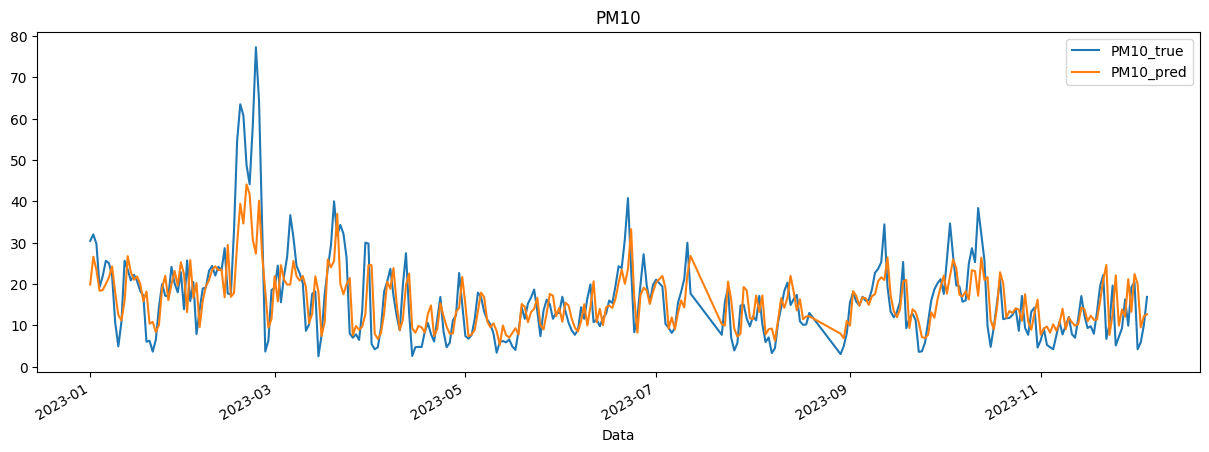

In [28]:
test.loc["2023-01-01":, ["PM10_true", "PM10_pred"]].plot(figsize=(15, 5), title="PM10")

<Axes: xlabel='Data'>

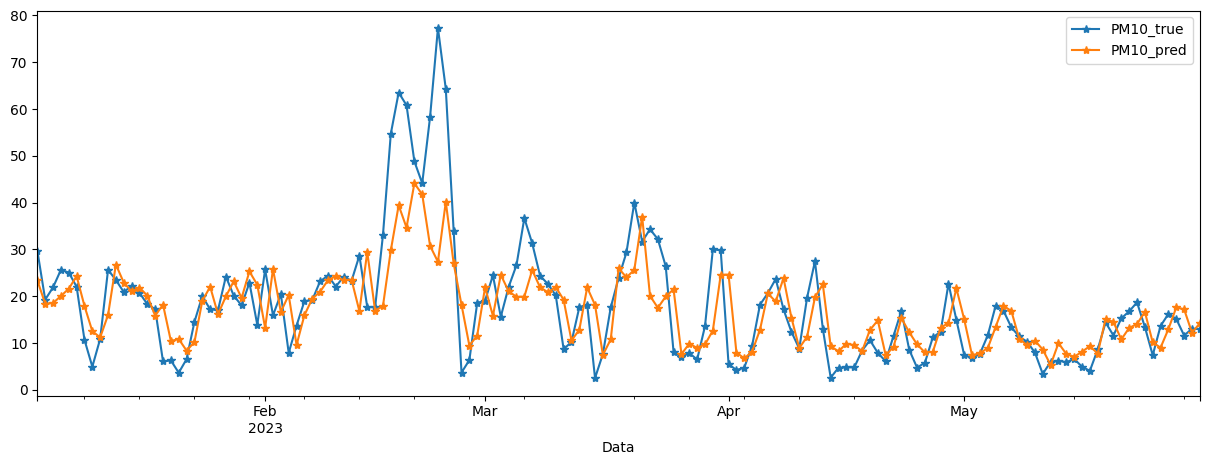

In [29]:
test["2023-01-03":"2023-05-31"].plot(figsize=(15, 5), marker="*")

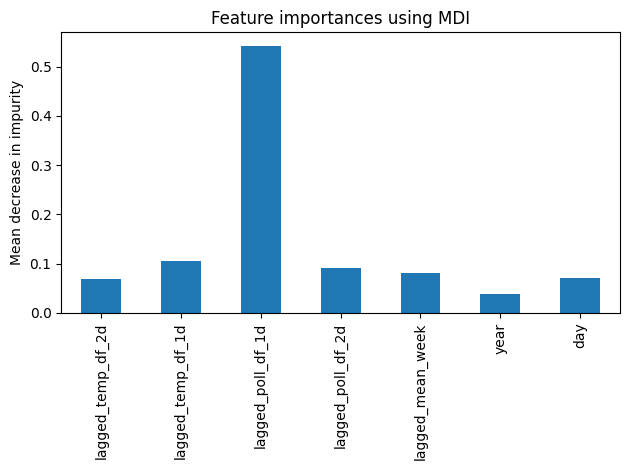

In [30]:
from matplotlib import pyplot as plt

forest_importances = pd.Series(model.feature_importances_, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

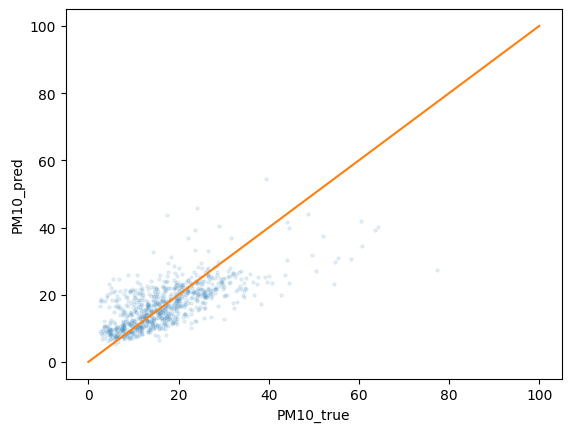

In [31]:
ax = test.plot.scatter(x="PM10_true", y="PM10_pred", alpha=0.1, marker=".")
ax.plot([0, 100], [0, 100], c="C1")


# Osservazioni